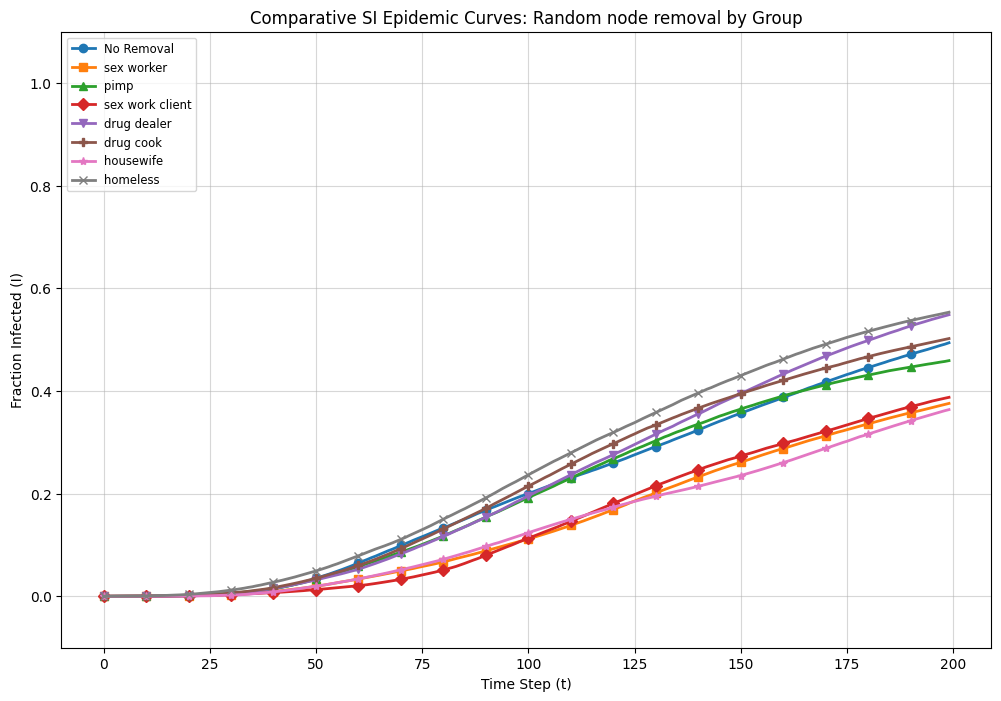

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import polars as pl
import pandas as pd

edges = pd.read_csv("edges.csv")
column_map = {col: col.strip() for col in edges.columns}
edges = edges.rename(columns=column_map)

G = nx.from_pandas_edgelist(edges, source="node1", target="node2")

nodes_pl = pl.read_csv(
    "nodes.csv",
    separator=",",
    encoding="utf8-lossy",
    ignore_errors=True)

nodes_df = nodes_pl.to_pandas()
nodes_df.columns = nodes_df.columns.str.strip()
nodes_df = nodes_df.set_index('id')

attribute_cols = ['sex.worker', 'pimp', 'sex.work.client', 'drug.dealer', 'drug.cook', 'housewife', 'homeless']
for col in attribute_cols:
    if col in nodes_df.columns:
        nodes_df[col] = nodes_df[col].fillna(0).astype(int)

def SI_sim_targeted_removal(T, G, beta, runs, attribute_cols, nodes_df, num_removed):
   
    average_I_history = []
    
    #
    target_node_labels = nodes_df[nodes_df[attribute_cols] == 1].index.tolist()

    
    removed_nodes = list(np.random.choice(target_node_labels, size=min(num_removed, len(target_node_labels)), replace=False))
    
   
    remaining_nodes = [node for node in G.nodes() if node not in removed_nodes]
    G_sub = G.subgraph(remaining_nodes).copy()
    A = nx.to_numpy_array(G_sub)
    N_sub = G_sub.number_of_nodes()

    if N_sub == 0:
        return np.zeros(T)

    
    for trial in range(runs):
        initial_case_idx = np.random.randint(N_sub)

        S0 = np.ones(N_sub)
        S0[initial_case_idx] = 0
        I0 = np.zeros(N_sub)
        I0[initial_case_idx] = 1

        S = [S0]
        I = [I0]

        for t in range(T - 1):
            prob_array = (A @ I[t] * beta * S[t])
            I_new = np.zeros(N_sub)
            
            for i in range(N_sub):
                if I[t][i] == 0:
                    I_new[i] = (np.random.rand() < prob_array[i])
                else:
                    I_new[i] = 1

            S.append(1 - I_new)
            I.append(I_new)

        average_I_history.append([j.mean() for j in I])
    
    average_I_history = np.array(average_I_history)
    return average_I_history.mean(axis=0)

T = 200
beta = 0.01
runs = 20
target_groups = [
    'sex.worker', 'pimp', 'sex.work.client', 'drug.dealer', 'drug.cook',
    'housewife', 'homeless']
results = {}

results['No Removal'] = SI_sim_targeted_removal(T, G, beta, runs, 'sex.worker', nodes_df, num_removed=0)

final_T = T
for group in target_groups:
    if group in nodes_df.columns:
        avg_curve = SI_sim_targeted_removal(T, G, beta, runs, group, nodes_df, num_removed=56)
        results[group] = avg_curve

markers = ['o', 's', '^', 'D', 'v', 'P', '*', 'x'] 
plt.figure(figsize=(12, 8))
for i, (group, avg_curve) in enumerate(results.items()):
    time = range(len(avg_curve))

    plt.plot(time, avg_curve, label=group.replace('.', ' '),
             marker=markers[i % len(markers)], markevery=10, linewidth=2)

plt.title('Comparative SI Epidemic Curves: Random node removal by Group')
plt.xlabel('Time Step (t)')
plt.ylabel('Fraction Infected (I)')
plt.ylim(-0.1, 1.1)
plt.legend(loc='upper left', fontsize='small')
plt.grid(True, alpha=0.5)


plt.savefig('si_comparative_random_removal_strategies_full.png', dpi=600)
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import polars as pl
import pandas as pd

edges = pd.read_csv("edges.csv")
column_map = {col: col.strip() for col in edges.columns}
edges = edges.rename(columns=column_map)

G = nx.from_pandas_edgelist(edges, source="node1", target="node2")

nodes_pl = pl.read_csv(
    "nodes.csv",
    separator=",",
    encoding="utf8-lossy",
    ignore_errors=True)

nodes_df = nodes_pl.to_pandas()
nodes_df.columns = nodes_df.columns.str.strip() 
nodes_df = nodes_df.set_index('id')

attribute_cols = ['sex.worker', 'pimp', 'sex.work.client', 'drug.dealer', 'drug.cook', 'housewife', 'homeless']
for col in attribute_cols:
    if col in nodes_df.columns:
        nodes_df[col] = nodes_df[col].fillna(0).astype(int)

def SI_sim_targeted_removal(T, G, beta, runs, attribute_column, nodes_df, num_removed):
   
    average_I_history = []
    
    
    target_node_labels = nodes_df[nodes_df[attribute_column] == 1].index.tolist()

    
    target_degrees = {node: G.degree[node] for node in target_node_labels if node in G}
    
    #
    removed_nodes = sorted(target_degrees, key=target_degrees.get, reverse=True)[:num_removed]
    
    # 
    remaining_nodes = [node for node in G.nodes() if node not in removed_nodes]
    G_sub = G.subgraph(remaining_nodes).copy()
    A = nx.to_numpy_array(G_sub)
    N_sub = G_sub.number_of_nodes()

    if N_sub == 0:
        return np.zeros(T)

    
    for trial in range(runs):
        
        
        initial_case_idx = np.random.randint(N_sub) 

        
        S0 = np.ones(N_sub) 
        S0[initial_case_idx] = 0
        I0 = np.zeros(N_sub)
        I0[initial_case_idx] = 1

        S = [S0]
        I = [I0]

        for t in range(T-1):
            prob_array = (A @ I[t] * beta * S[t])
            I_new = np.zeros(N_sub)
            
            for i in range(N_sub):
                if I[t][i] == 0:
                    I_new[i] = (np.random.rand() < prob_array[i])
                else:
                    I_new[i] = 1

            S.append(1-I_new)
            I.append(I_new)

        average_I_history.append([j.mean() for j in I])
    
    average_I_history = np.array(average_I_history)
    return average_I_history.mean(axis=0)

T = 200
beta = 0.01
runs = 20 
target_groups = [
    'sex.worker', 'pimp', 'sex.work.client', 'drug.dealer', 'drug.cook'
    , 'housewife' , 'homeless'] 
results = {}

results['No Removal'] = SI_sim_targeted_removal(T, G, beta, runs, 'sex.worker', nodes_df, num_removed=0)

final_T = T
for group in target_groups:
    
    if group in nodes_df.columns:
        avg_curve = SI_sim_targeted_removal(T, G, beta, runs, group, nodes_df, num_removed=56)
        results[group] = avg_curve

markers = ['o', 's', '^', 'D', 'v', 'P', '*', 'x'] 
plt.figure(figsize=(12, 8))
for i, (group, avg_curve) in enumerate(results.items()):
    time = range(len(avg_curve))

    plt.plot(time, avg_curve, label=group.replace('.', ' '),
             marker=markers[i % len(markers)], markevery=10, linewidth=2)

plt.title(f'Comparative SI Epidemic Curves: Targeted node removal by Group)')
plt.xlabel('Time Step (t)')
plt.ylabel('Fraction Infected (I)')
plt.ylim(-0.1, 1.1)
plt.legend(loc='upper left', fontsize='small')
plt.grid(True, alpha=0.5)

plt.savefig('si_comparative_removal_strategies_full.png', dpi=600)